<a href="https://colab.research.google.com/github/ramdas21921/Data-Analytics-Projects/blob/main/Ramdas_E_Bike_sharing_service_demand_estimation_and_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Micro mobility service provider(E-bike Sharing) : Demand estimation and Improvement Analysis**

**Problem Statement:**

*   Company XYZ- India's one of the top micro mobility service provider through Electric bikes and their charging station network.
*   Recently, they are facing lower demands for vehicles compared to the expectation and they want to know the factors actually deriving daily demands in Indian Market.
*   How well these factors suggest electric bikes demand?

*   Based on this they want ot make informed strategic changes on demand generation to improve revenue and profit for the Company XYZ






In [ ]:
import pandas as pd
import numpy as np
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,binom,geom,stats
from scipy.stats import chi2_contingency,f_oneway,levene,ttest_ind,ttest_rel,kruskal,shapiro

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


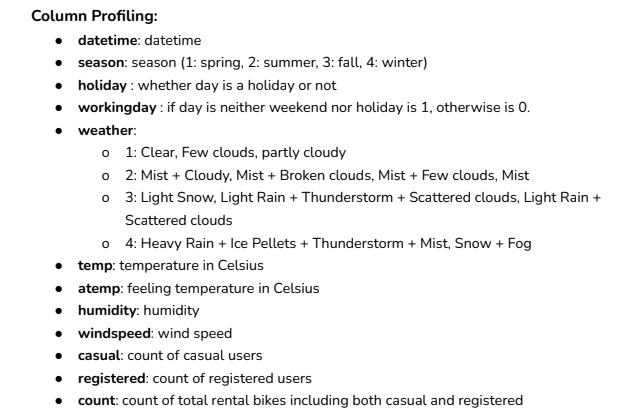

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/bike_sharing.csv")
print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,01-01-2011 00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,01-01-2011 01:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,01-01-2011 02:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,01-01-2011 03:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,01-01-2011 04:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Here,
**Target Variable = 'count'** (Dependent variable)

remaining columns are features (independent variable)

In [ ]:
# Encoding Categorical columns in respective category instead of numeric values
def encode_weather(row):
  if row['weather']==1:
    return 'Partly Cloudy'
  elif row['weather']==2:
    return '(Mist + Cloudy)'
  elif row['weather']==3:
    return '(Light Rain + Scattered clouds)'
  elif row['weather']==4:
    return 'Heavy Rain'

def encode(row):
  if row['season']==1:
    return 'Spring'
  elif row['season']==2:
    return 'Summer'
  elif row['season']==3:
    return 'Fall'
  elif row['season']==4:
    return 'Winter'

def encode_working_day(row):
  if row['workingday']==1:
    return 'Working Day'
  else:
    return 'Non Working Day'

def encode_holiday(row):
  if row['holiday']==1:
    return 'Holiday'
  else:
    return 'No Holiday'

df.weather= df.apply(encode_weather,axis=1)
df.season= df.apply(encode,axis=1)
df.workingday=df.apply(encode_working_day,axis=1)
df.holiday= df.apply(encode_holiday,axis=1)




In [ ]:
df.datetime=pd.to_datetime(df.datetime,format='%d-%m-%Y %H:%M')

In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,75,0.0,0,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  object        
 2   holiday     10886 non-null  object        
 3   workingday  10886 non-null  object        
 4   weather     10886 non-null  object        
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 1020.7+ KB


In [ ]:
np.any(df.duplicated())

False

In [ ]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

From above dataset, we can colnclude

*   There are 10,886 rows and 12 unique columns
*   After transformation, (6+3) numerical columns  ,2 categorical columns and 1 datetime column
*   There are no null values present in any of the column
*   Rows are not duplicated




In [ ]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [ ]:
df.describe()

,datetime,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [ ]:
# description of categorical columns
df.describe(include=['object'])

,season,holiday,workingday,weather
count,10886,10886,10886,10886
unique,4,2,2,4
top,Winter,No Holiday,Working Day,Partly Cloudy
freq,2734,10575,7412,7192


In [ ]:
print(df.datetime.min(),df.datetime.max())

2011-01-01 00:00:00 2012-12-19 23:00:00


We can observe,

1.   **More than 75% of the days are working days** in given dataset

2.   Mean and Medium temp. of actual temp,feeling temp,humidity,windspeed are close to each other **depicting minimum skewness in the data**, but minimum temp is going to 0 degree celsius which is critical for Indian region.

3.   Higher mean than median for casual users,registered users and count of bikes rented depicts right skewed data, with few outliers on higher side of the data. On an avg. 145 bikes are being rented per hour with best sell of 977 bikes in an hour.
4.   Data considered of 2 years starting from 1st Jan 2011
5.   Significant portion of the time(>70%) there is partly cloudy weather outside.





# Outlier Detection and removal

In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,75,0.0,0,1,1


In [ ]:
# filter the numeric variables from the data
num_cols = df.select_dtypes(include = np.number)
num_cols.head()

,temp,atemp,humidity,windspeed,casual,registered,count
0,9.84,14.395,81,0.0,3,13,16
1,9.02,13.635,80,0.0,8,32,40
2,9.02,13.635,80,0.0,5,27,32
3,9.84,14.395,75,0.0,3,10,13
4,9.84,14.395,75,0.0,0,1,1


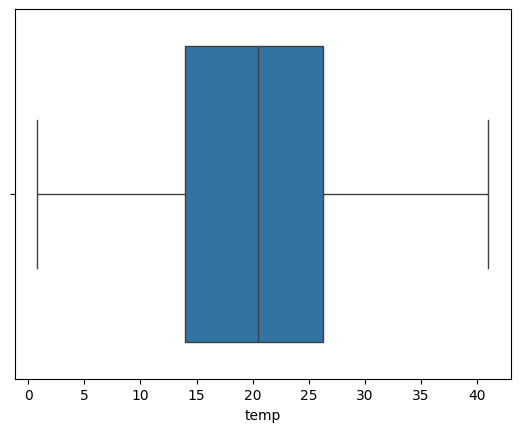

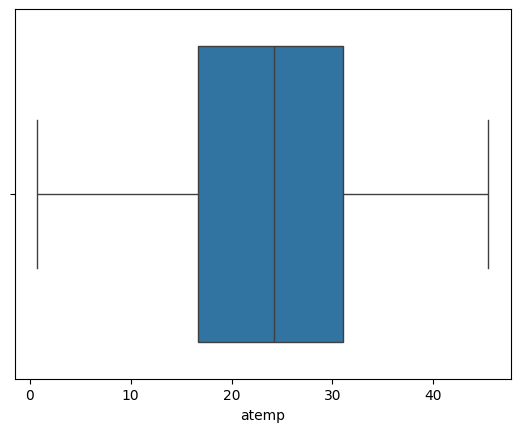

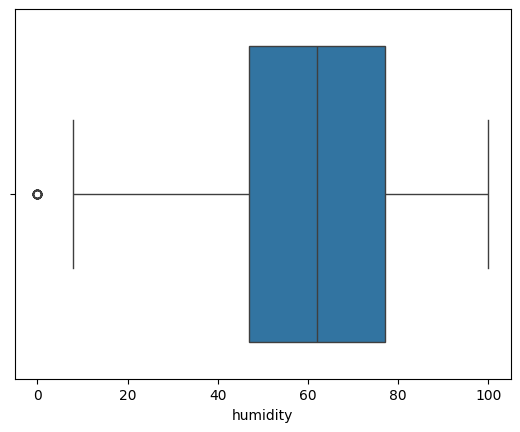

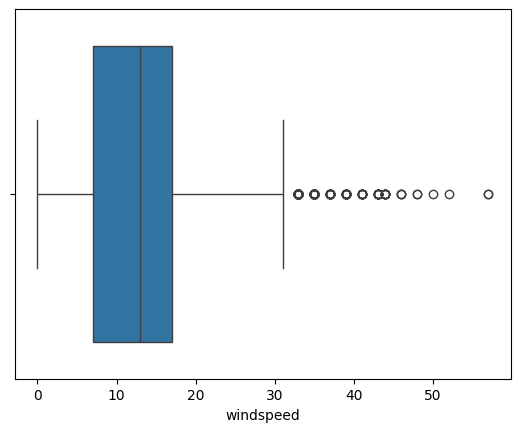

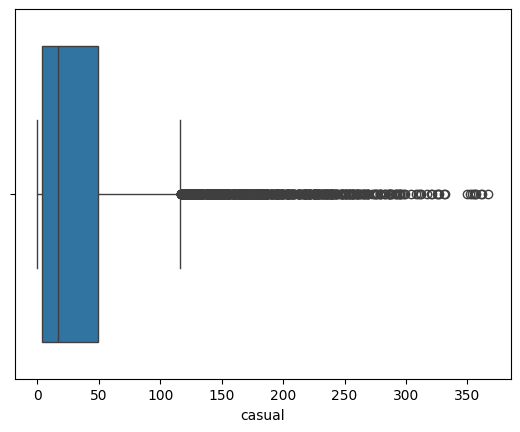

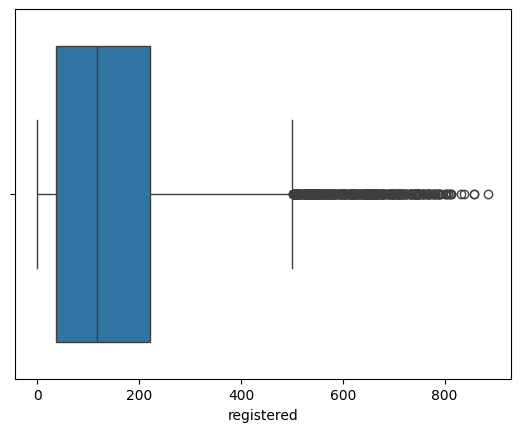

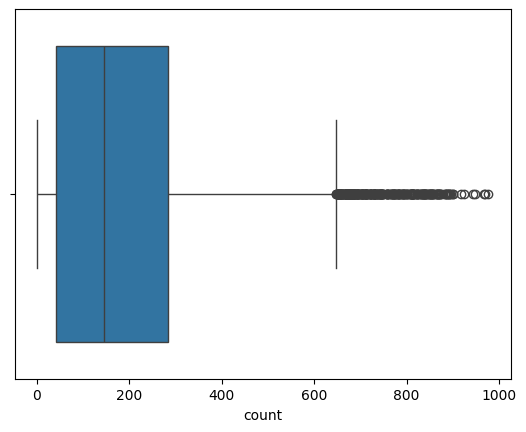

In [ ]:
for column in enumerate(num_cols):
    sns.boxplot(x=column[1],data=num_cols)
    plt.show()

 Lets **remove the outliers visible in above numerical columns by using Z score**

 Assuming +3 to -3 Z score as cutoff scores and remove rows where all columns are outliers



In [ ]:
num_cols1=num_cols[['windspeed','casual','registered','count']]

z_scores = np.abs(stats.zscore(num_cols1))

<ipython-input-33-9589b7fc9610>:3: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  z_scores = np.abs(stats.zscore(num_cols1))


In [ ]:
df.shape

(10886, 12)

In [ ]:
df= df[(z_scores < 3).all(axis=1)]
df.shape

(10293, 12)

**Here all the outliers containing 593 rows has been removed**

# **Skewness Checking through KDE plots**




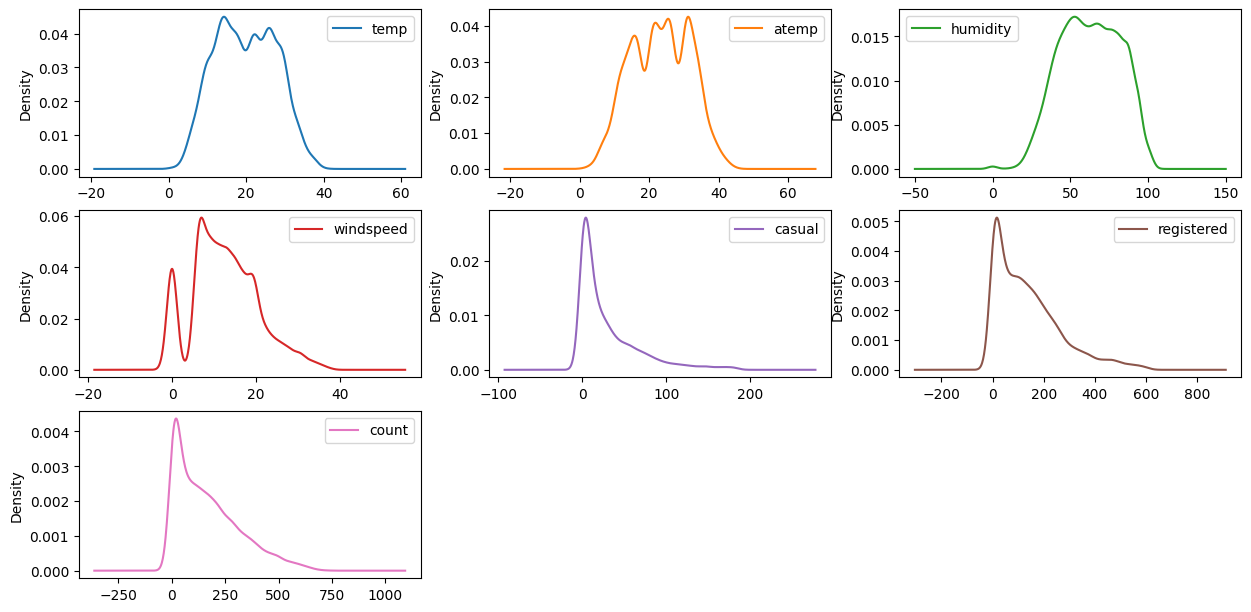

In [ ]:

plt.rcParams["figure.figsize"] = [15,10]
num_df=df[[ 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']]
num_df.plot(kind = 'kde', subplots = True, layout = (4,3), sharex = False)
plt.show()

In [ ]:
print(num_df.skew())

temp          0.054431
atemp        -0.048143
humidity     -0.110963
windspeed     0.401331
casual        1.825557
registered    1.179203
count         0.946800
dtype: float64


**Insights:**
*   **High positive skewness in Holiday** confirms significant portion of non-holiday days in the data.
*   Medium positive skewness in casual users,registered users and count of rented bikes **shows high density of low number of users/bike sold but few outliers at higher side with extreme values.**
*   All other numerical columns are showing minimal skewness and evenely distributed.






**Correlation in Numerical features**

<Axes: >

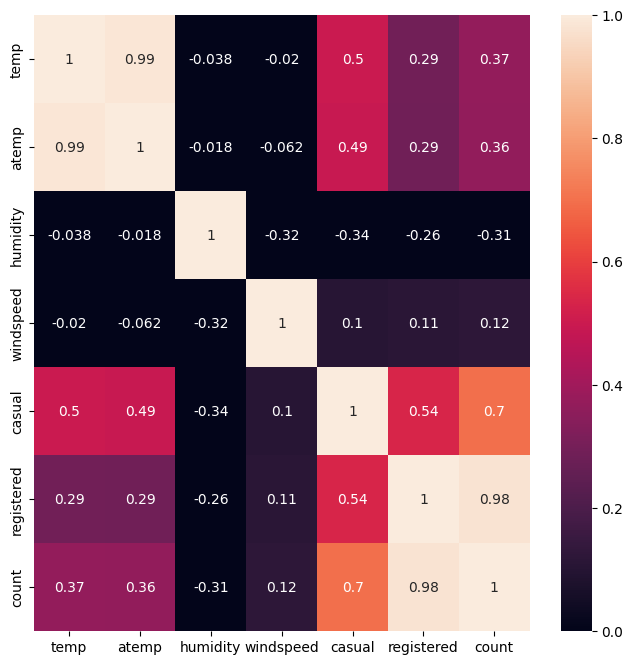

In [ ]:
num_corr=num_df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(num_corr,vmin=0,vmax=1,annot=True)

**Insights:**

a)Correlation heatmap depicts highest positive correlation between below 2 column

**temp & atemp : 0.98**

casual users & registered uers=0.5

b) **Negative correlation of -0.35** between humidity and casual users showing **as humidity increases casual users opt less for renting a bike.**

**As visible from heatmap and uni-variate analysis of ratio(temp/atemp)** clearly suggest we should ommit atemp(feeling temp) column from analysis, to **maintain independency between the columns**.

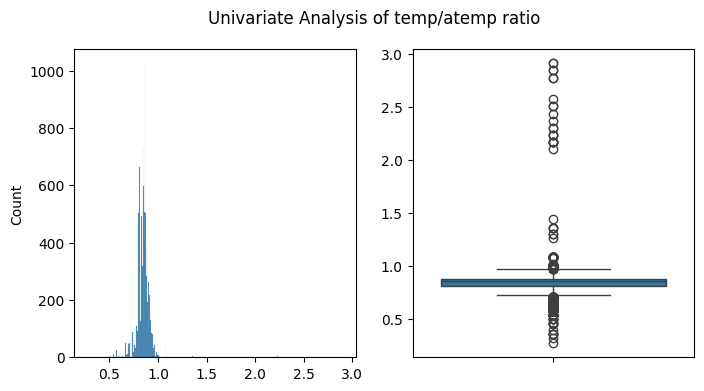

In [ ]:
plt.figure(figsize=(8,4))
plt.suptitle('Univariate Analysis of temp/atemp ratio')
plt.subplot(1,2,1)
sns.histplot(df.temp/df.atemp)
plt.subplot(1,2,2)
sns.boxplot(df.temp/df.atemp)
plt.show()

# Bi-Variate Analysis:

<Axes: xlabel='weather', ylabel='count'>

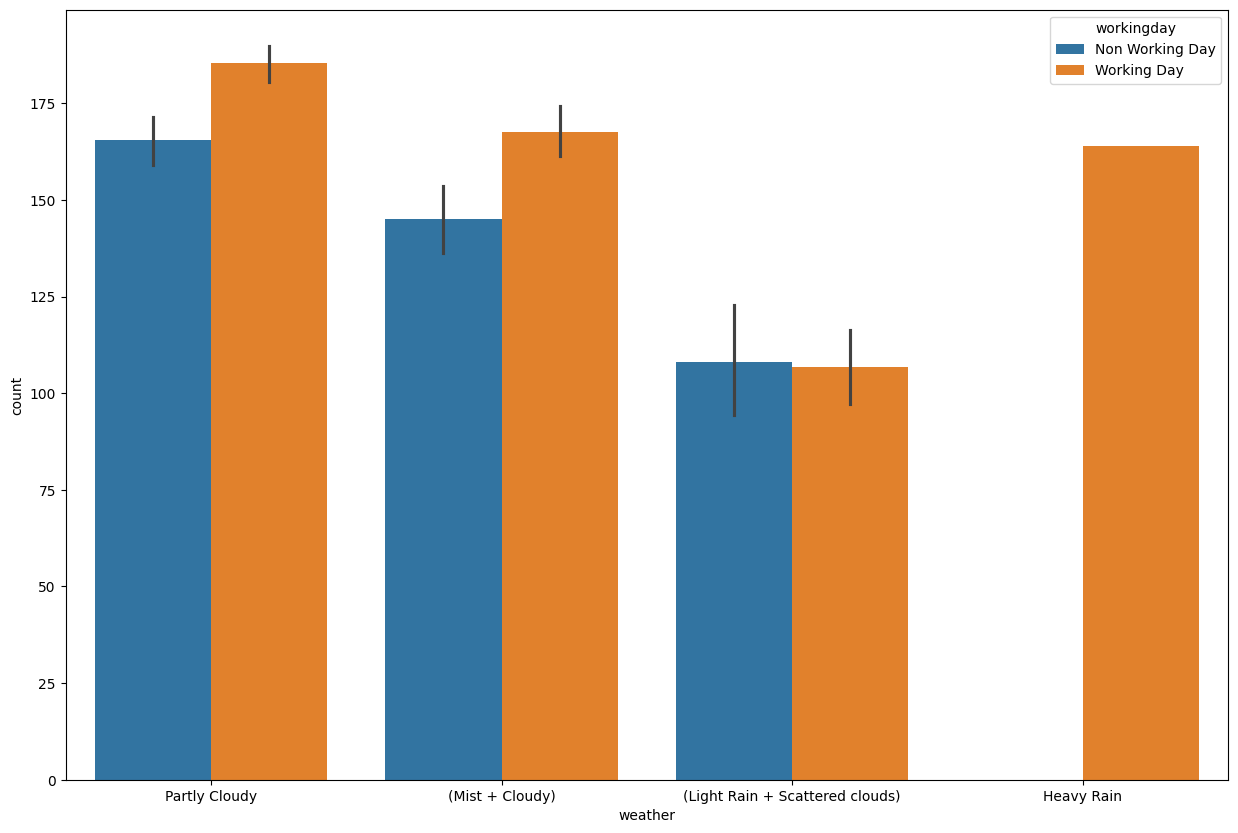

In [ ]:
sns.barplot(data=df,x='weather',y='count',hue='workingday')

**Insights:**

Avg rented bikes are **highest on partly cloudy weather** and followed by (mist+cloudy) season.

It seems **bikes rented on working days is slightly higher than non-working days** **irresective of season but need to check for signifcance**.

# Does on Particular Day of the week, demand is highest?

<Axes: xlabel='day_name', ylabel='count'>

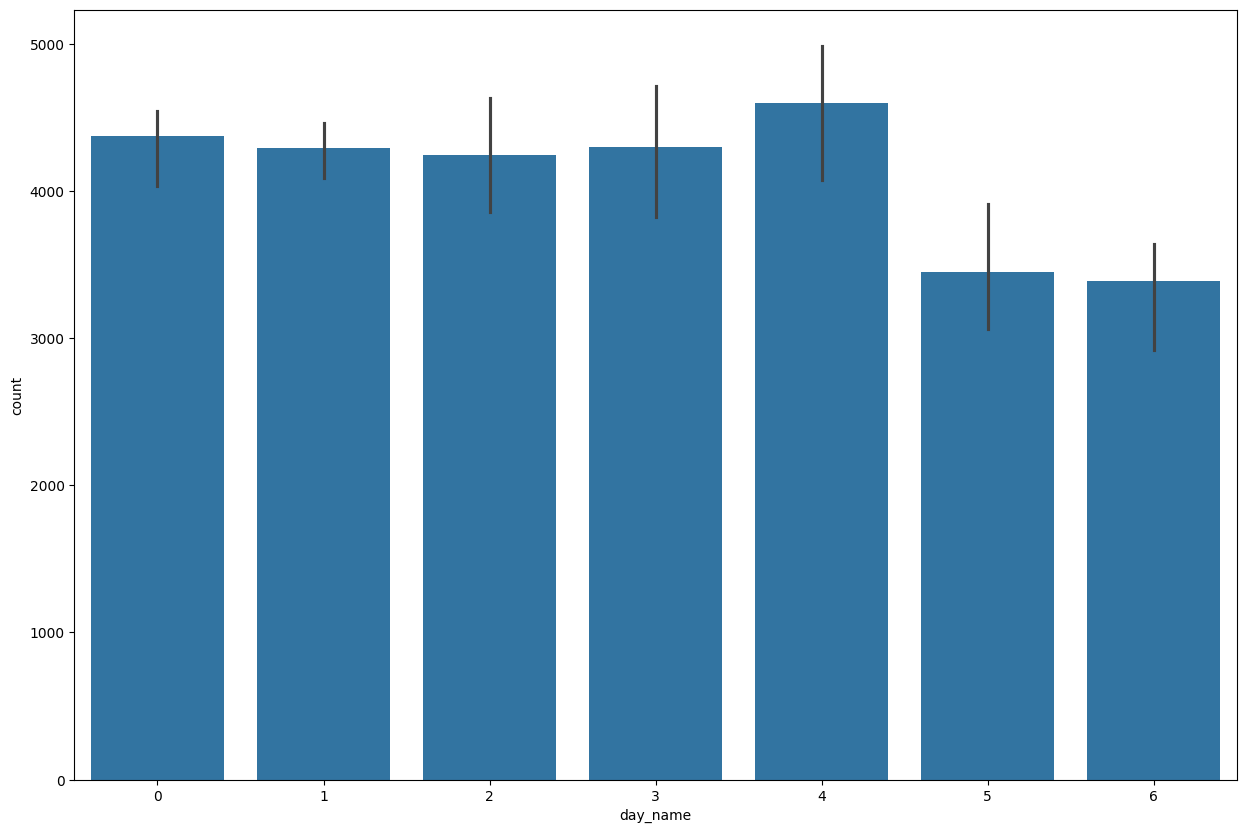

In [ ]:
# Here Day=0 is Monday
df["date"]=df["datetime"].dt.date
df['day_name']=df['datetime'].dt.dayofweek
df1=df.groupby(['date','day_name'])['count'].sum()
df1=df1.reset_index()
df1
sns.barplot(data=df1,x='day_name',y='count',estimator='median')

**Insights:**

(# Here Day=0 is Monday)

*   **Monday, Tues and Friday seems to be relatively better demand days** for renting bikes.
*   **Demand gets lowered during Thur and Sat**(counter-intuitive, given relative weekend)

Recommendations:

*   We should continue out focus on best selling days of the week i.e. Monday,Tues and Fridays.
*   We need to deep dive further for lower demand on Thurs and Saturday and plan for improvement.





# 3. Check if there any significant difference between the no. of bike rides on Working day and Non-working days?

In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,day_name
0,2011-01-01 00:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,81,0.0,3,13,16,2011-01-01,5
1,2011-01-01 01:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.02,13.635,80,0.0,8,32,40,2011-01-01,5
2,2011-01-01 02:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.02,13.635,80,0.0,5,27,32,2011-01-01,5
3,2011-01-01 03:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,75,0.0,3,10,13,2011-01-01,5
4,2011-01-01 04:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,75,0.0,0,1,1,2011-01-01,5


In [ ]:
# Aggregating at each date level from hourly data


new_df=df.groupby(["date","workingday"])["count"].sum()
new_df=new_df.reset_index()

In [ ]:
working_day_rides=new_df[new_df["workingday"]=='Working Day']['count']
non_working_day_rides=new_df[new_df["workingday"]=='Non Working Day']['count']


Assumed significance level-0.05

Test - Sample Independent T-test

Assumption for above test:
*   rows are independet of each other
*   Each group data is normally distributed
*   Equal variance between groups






# Validation of assumptions
a) **Normal distribution check**

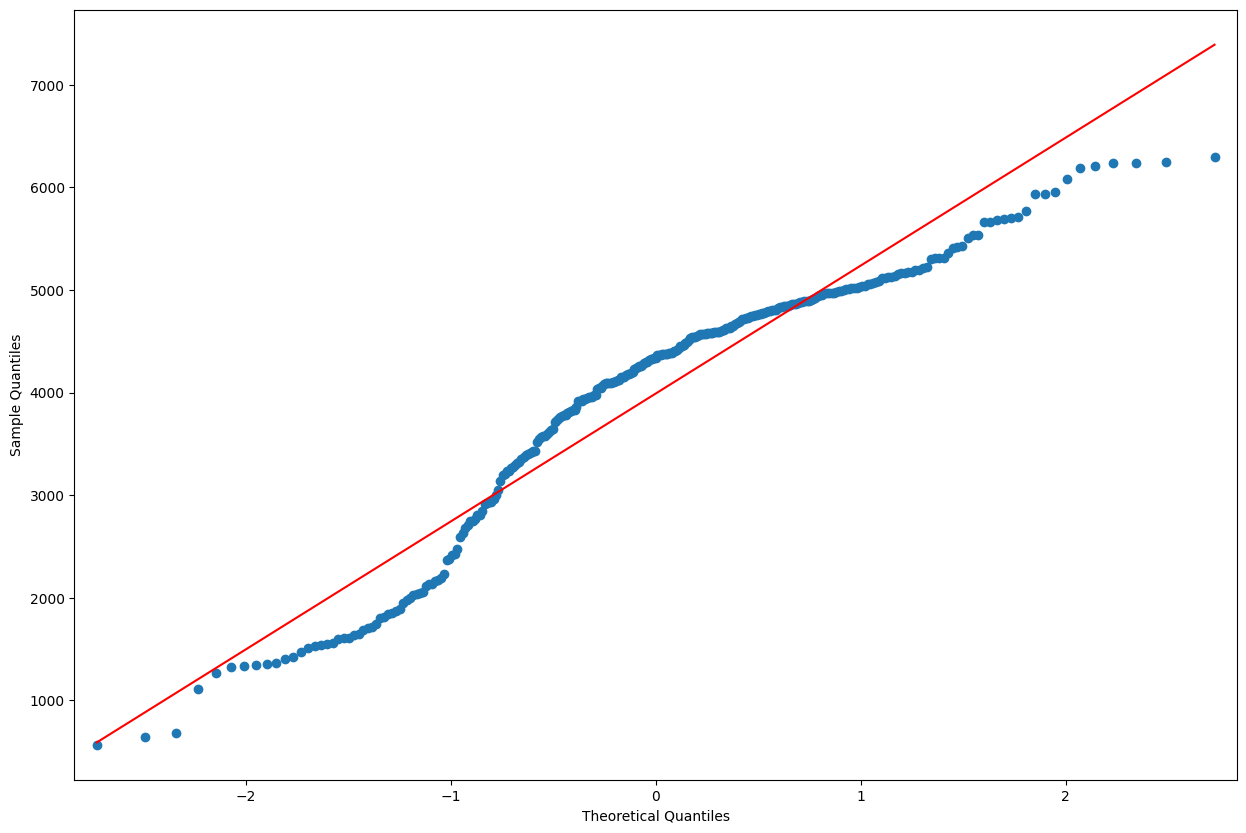

In [ ]:


import statsmodels.api as sm
sm.qqplot(working_day_rides,line="s")
plt.show()


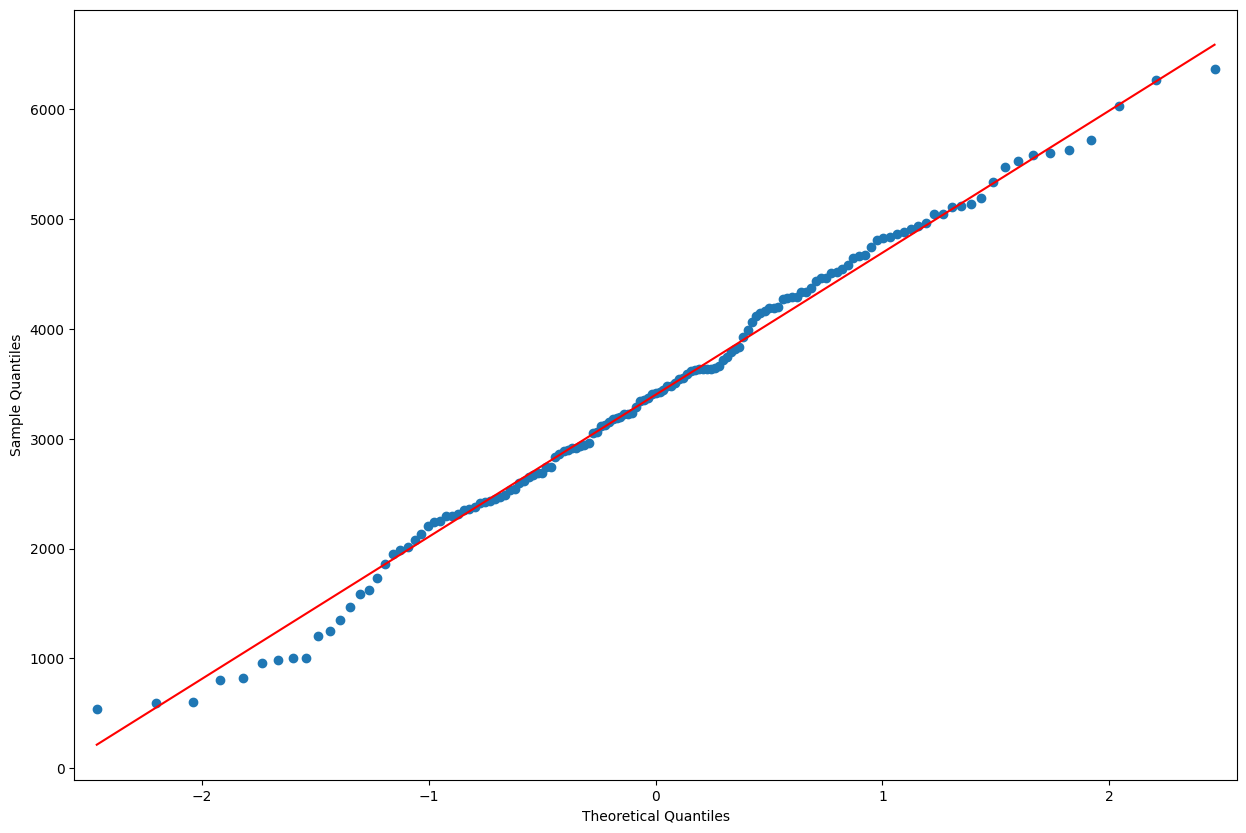

In [ ]:
# QQPLOT Check for normmmality on non-working days rides
sm.qqplot(non_working_day_rides,line="s")
plt.show()

As visible above, numbers are overlapping the red line **indicating normal distribution**

**b) Equal Variance Check using levene's test**

H0: given 2 groups have equal variance

Ha: given 2 groups do not have equal variance


In [ ]:
levene(working_day_rides,non_working_day_rides)

LeveneResult(statistic=1.0529034199369123, pvalue=0.30538574699465165)

Here **pvalue> 0.05(significance level), hence we fail to reject null hypothesis and we conclude variances are equal for 2 groups**





**Lets continue our Sample Independent T-test here**,

H0: mu(woking_day)=mu(non-working day)

Ha: mu(woking_day)>mu(non-working day)





In [ ]:
(stat, pvalue)=ttest_ind(working_day_rides,non_working_day_rides,alternative='greater')
print(f"statistics value= {stat} and P_value= {pvalue}")

statistics value= 4.629073300576099 and P_value= 2.4005585868066064e-06


Insight:

As p_value< 0.05, we reject null hypothesis, No of rides on working day is relatively higher than non-working day

Recommendation:

*   '# of rented bikes is dependent on whether it is working or non-working days.
*   Company XYZ should keep  marketing or reachout focus on working days than non-working days

# 4. Check if the demand of bicycles on rent is the same for different Weather conditions?

In [ ]:
df.weather.value_counts()

weather
Partly Cloudy                      6755
(Mist + Cloudy)                    2712
(Light Rain + Scattered clouds)     825
Heavy Rain                            1
Name: count, dtype: int64

In [ ]:
partly_cloudy_rides=df[df["weather"]=='Partly Cloudy']['count']
mist_cloudy_rides=df[df["weather"]=='(Mist + Cloudy)']['count']
light_rain_rides=df[df["weather"]=='(Light Rain + Scattered clouds)']['count']
heavy_rain_rides=df[df["weather"]=='Heavy Rain']['count']


Given more than 2 groups, we should go with ANOVA/Kruskal test after assumption validations


**Assumption for ANOVA test:**
*   rows are independet of each other
*   Each group data is normally distributed
*   Equal variance between groups






# Assumption Validation:

**a) Normality test using QQ plot,boxplot**

Skewness= 0.8588740642792089  Kurtosis=  0.034508546650116934


<Axes: xlabel='count', ylabel='Count'>

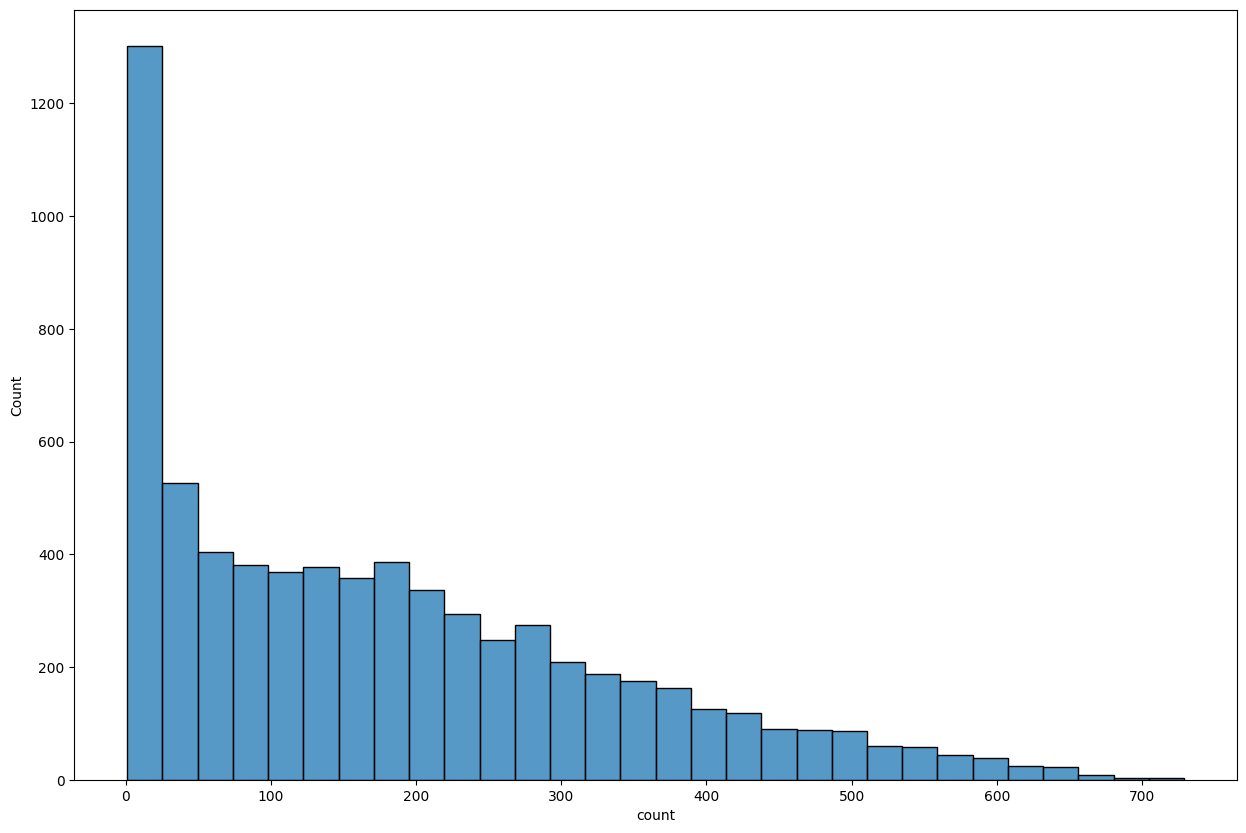

In [ ]:
print('Skewness=',partly_cloudy_rides.skew()," Kurtosis= ",partly_cloudy_rides.kurtosis() )
sns.histplot(partly_cloudy_rides)

There is **postive skewness depicting few cases where there are extreme no. of rented bikes** and most of others are in range



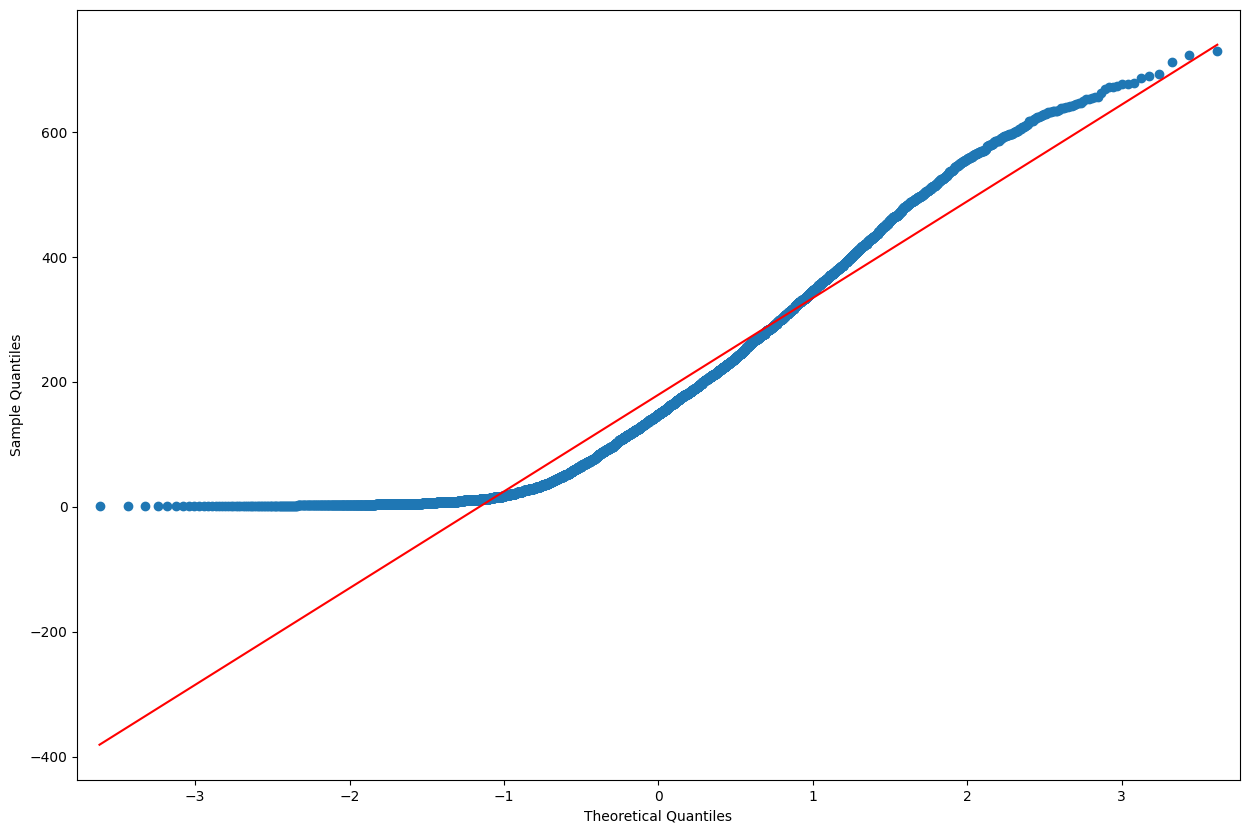

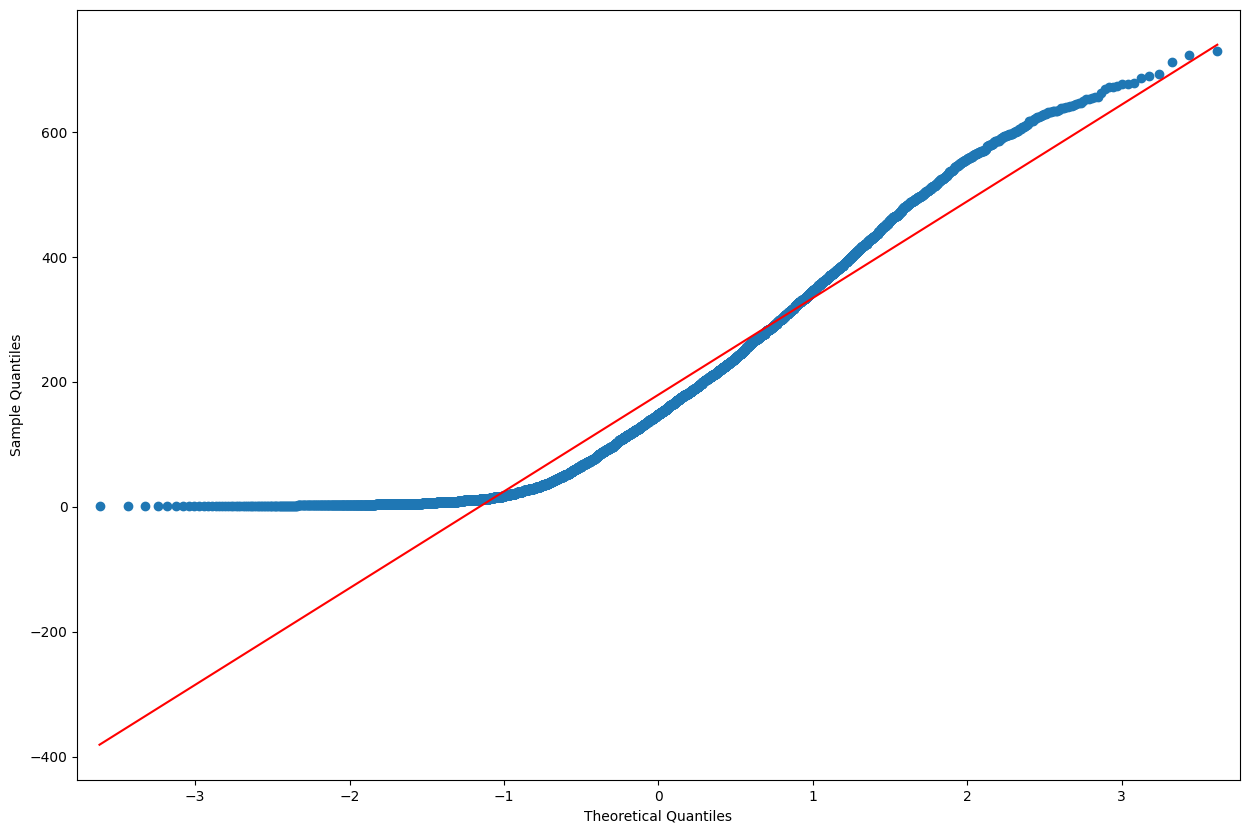

In [ ]:
from statsmodels.graphics.gofplots import qqplot
qqplot(partly_cloudy_rides,line="s")

In [ ]:
# Using Shapiro test for checking normal distr. of data

# H0: Data is Gaussian
# Ha: Data is not Gaussian
shapiro(partly_cloudy_rides)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9131437540054321, pvalue=0.0)

**pvalue <0.5 confirms data is non-gaussian**

**b) Equal Variance Check using levene's test**

H0: All groups have equal variance

Ha: All groups do not have equal variance


In [ ]:
levene(partly_cloudy_rides,mist_cloudy_rides,light_rain_rides,heavy_rain_rides)

LeveneResult(statistic=57.421061945480545, pvalue=8.359347850386003e-37)

Here **pvalue << 0.05(significance level), hence we reject null hypothesis and we conclude Variance of the few groups differ from others**

As these groups does not follow normality distribution and equal variance criteria, we are **going with Kruskal test**





H0: Medians of all groups are same

Ha: Medians of all groups are different


Assumed significance level-0.05

In [ ]:
kruskal(partly_cloudy_rides,mist_cloudy_rides,light_rain_rides,heavy_rain_rides)

KruskalResult(statistic=176.89502230527225, pvalue=4.130155912772492e-38)

As seen from above Kruskal test results, p value << 0.05  hence we reject null hypothesis i.e. **atleast for 1 pair of above groups, median does not match**

# Identifying which pair has different mean using ttest_ind

In [ ]:

# H0: mu1=mu2
# Ha: Mu1>mu2

(stat,pvalue)=ttest_ind(partly_cloudy_rides,mist_cloudy_rides,alternative='greater')
print(pvalue)


3.67163627214384e-08


**rejcting null hypothesis i.e. No of rides on partly cloudy rides are usually higher than mist+ cloudy weather**

In [ ]:
# Identifying which pair has different mean using ttest_ind
# H0: mu1=mu2
# Ha: Mu1>mu2

(stat,pvalue)=ttest_ind(mist_cloudy_rides,light_rain_rides,alternative='greater')
print(pvalue)

# comparison with heavy rains is not useful, as only 1 rows are there

2.8728465494634903e-23


# Insights & Recommendation:

*   **No. of mean rides are increasing with clearer,sunny weather and getting hampered with cloudy and rainy days**
*   micro mobility service provider must imphasis on **putting close watch on weather forecast** and plan resources for clearer sunny days.

*  **Higher discounts and marketing efforts needed on relatively misty,cloudy or rainy days** to uplift the mean sales






# 5. Check if the demand of bicycles on rent is the same for different Seasons?

In [ ]:
df.season.value_counts()

season
Winter    2621
Spring    2616
Summer    2531
Fall      2525
Name: count, dtype: int64

In [ ]:
Winter_rides=df[df["season"]=='Winter']['count']
Summer_rides=df[df["season"]=='Summer']['count']
Fall_rides=df[df["season"]=='Fall']['count']
Spring_rides=df[df["season"]=='Spring']['count']


Given more than 2 groups, we should go with ANOVA/Kruskal test after assumption validations

**Assumption for ANOVA test:**

rows are independet of each other

Each group data is normally distributed

Equal variance between groups

**Assumption Validations:**

a) Normality test using QQ plot,boxplot

Skewness= 0.7998282401717686  Kurtosis=  -0.07396121032711012


<Axes: xlabel='count', ylabel='Count'>

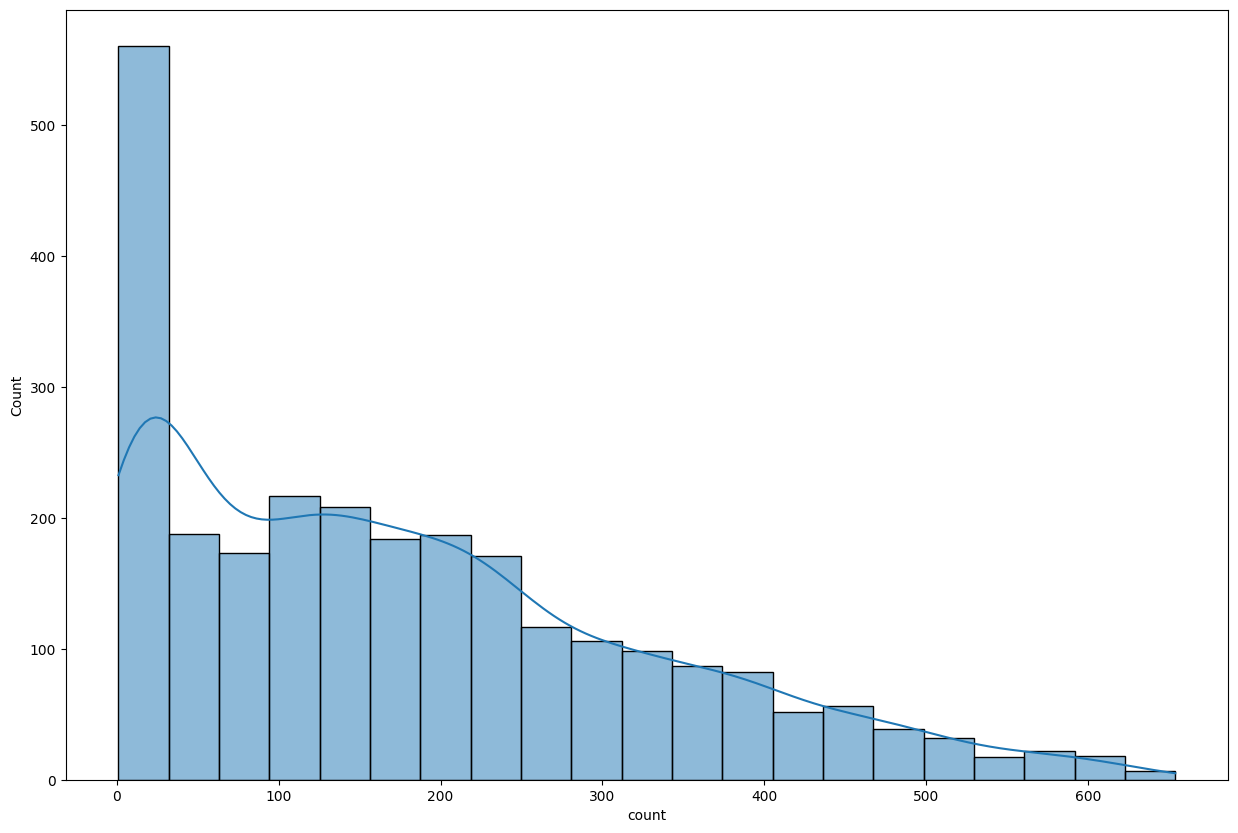

In [ ]:
print('Skewness=',Winter_rides.skew()," Kurtosis= ",Winter_rides.kurt() )
sns.histplot(Winter_rides,kde=True)

There is
postive skewness depicting few cases where there are sudden large no. of bikes demand was thereand most of others are in mid range

Positive Kurtosis depicts heavy tails i.e. heavy concentration around mean with some values at extreme high end


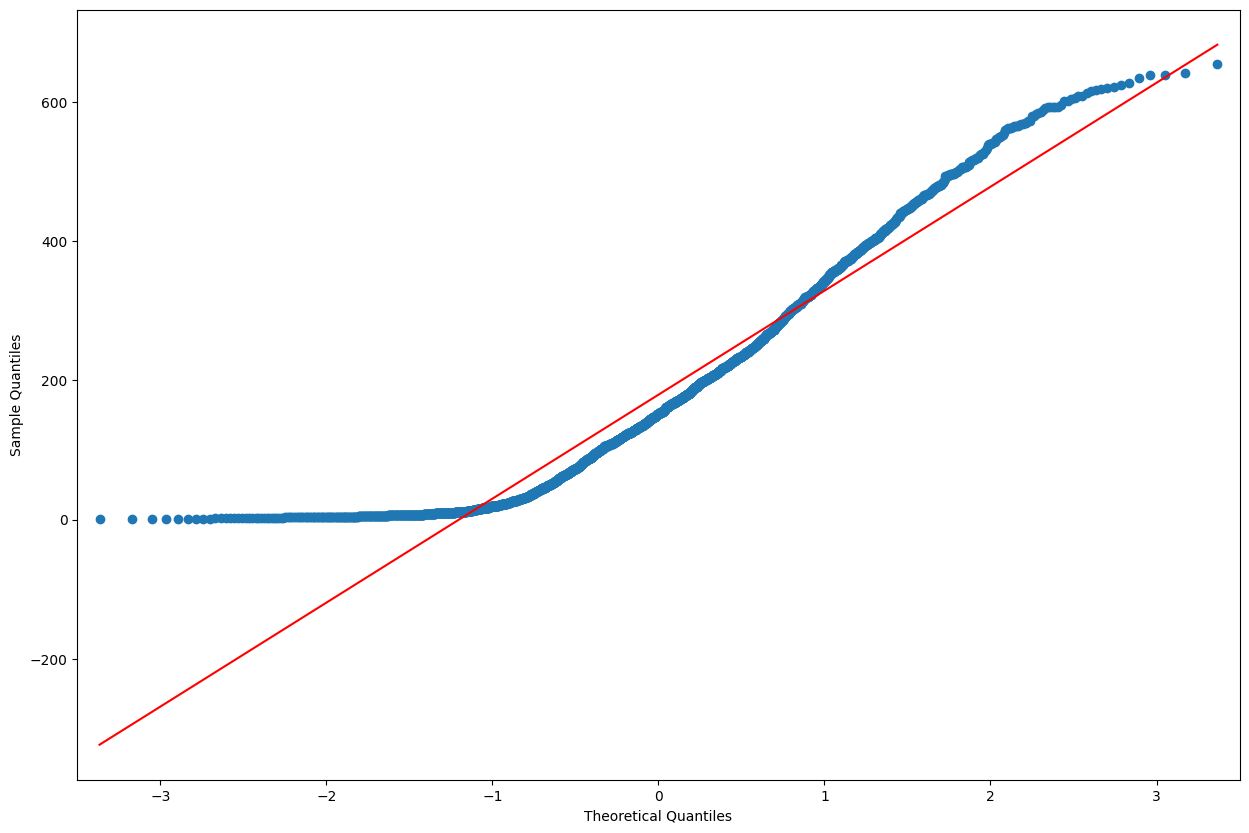

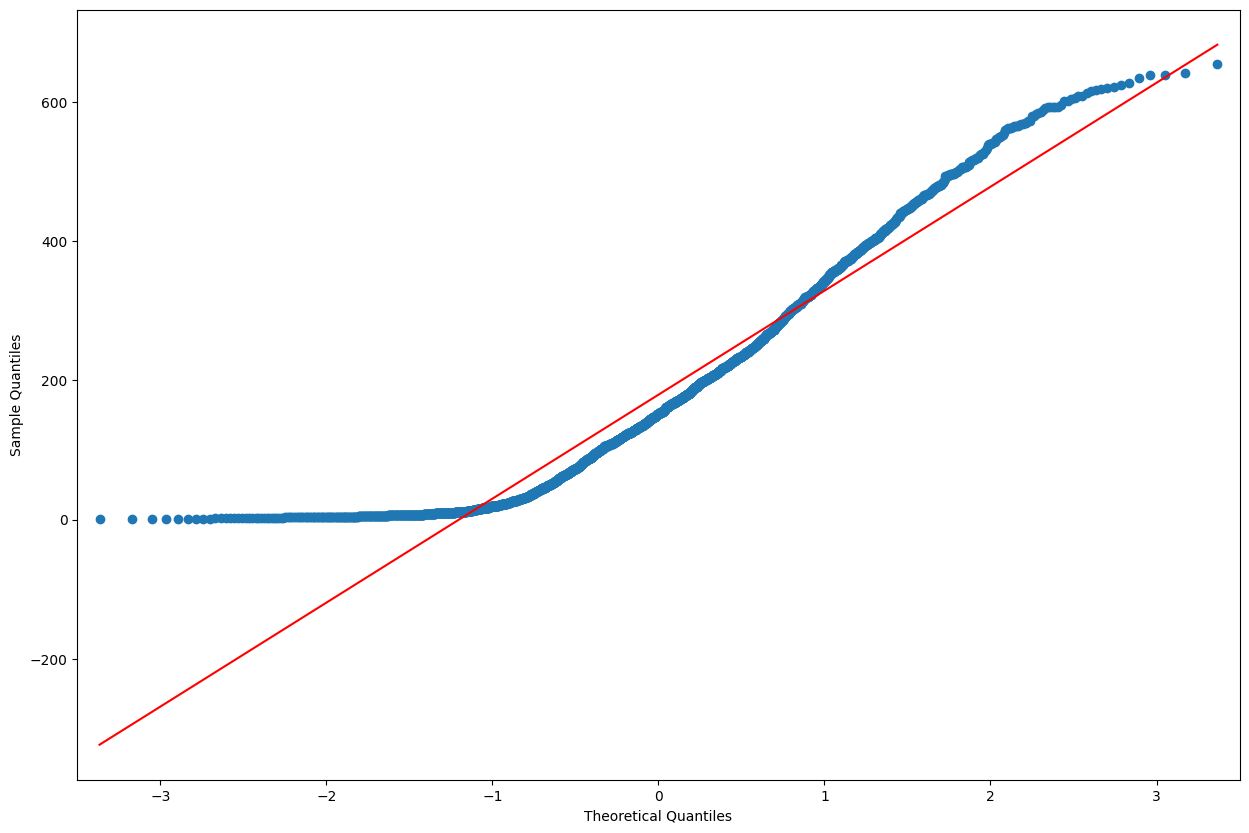

In [ ]:
from statsmodels.graphics.gofplots import qqplot
qqplot(Winter_rides,line="s")

 Using Shapiro test for checking normal distr. of data

 H0: Data is Gaussian

 Ha: Data is not Gaussian


In [ ]:
shapiro(Winter_rides)

ShapiroResult(statistic=0.9216601848602295, pvalue=6.554596104242793e-35)

Shapiro - pvalue < 0.05 depicts, we reject null hypo. and **given data is not gaussian**



**b) Equal Variance Check using levene's test**

H0: All groups have equal variance

Ha: All groups do not have equal variance

In [ ]:
levene(Winter_rides,Summer_rides,Fall_rides,Spring_rides)

LeveneResult(statistic=159.75958591249832, pvalue=3.2393243279855006e-101)

Here for levene's test
pvalue << 0.05(signifi cance level), hence we reject null hypothesis and we **conclude Variance of the few seasons differ from others**.


As these groups does not follow normality distribution and equal variance criteria, we are going with Kruskal test

H0: Medians of all groups are same
Ha: Medians of all groups are different

Assumed significance level-0.05

In [ ]:
kruskal(Winter_rides,Summer_rides,Fall_rides,Spring_rides)

KruskalResult(statistic=565.0592103479952, pvalue=3.7818568983867903e-122)

As seen from above Kruskal test results, p value << 0.05 hence we reject null hypothesis i.e. **atleast for 1 pair of above seasons, median does not match**.

# Identifying which pair has different mean using ttest_ind

 H0: mu1=mu2

 Ha: Mu1>mu2

In [ ]:
(stat,pvalue)=ttest_ind(Fall_rides,Summer_rides,alternative='greater')
print(pvalue)

3.057149688362658e-05


In [ ]:
(stat,pvalue)=ttest_ind(Summer_rides,Spring_rides,alternative='greater')
print(pvalue)

5.438750438305611e-81


In [ ]:
(stat,pvalue)=ttest_ind(Spring_rides,Winter_rides,alternative='less')
print(pvalue)

6.917869683138038e-77


**In all 3 comparisons above, p values are << 0.05 hence rejcting null hypothesis i.e. No of rides demand are highest on fall season followed by summer,spring and then winter season**

Recommendations:

*   **Fall season comes with highest demand for renting bikes and Company XYZ must prepare the necessary resources to encash maximum.**
*   **Root cause analysis is needed for lowest demand in winter season including internal and external factors** affecting and plan strategies to improve the same.



# 6. Check if the Weather conditions are significantly different during different Seasons?

In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,75,0.0,0,1,1


In [ ]:
a=pd.crosstab(index=df.weather,columns=df.season)
a

season,Fall,Spring,Summer,Winter
weather,,,,
(Light Rain + Scattered clouds),183,208,216,218
(Mist + Cloudy),557,703,668,784
Heavy Rain,0,1,0,0
Partly Cloudy,1785,1704,1647,1619


H0: weather and season are independent of each other

Ha: weather and season are not independent of each other i.e. weather
conditions remains similar in a given season

Assuming Alpha= 0.05

Using chi square contigency test

In [ ]:
chi_stat, p_value, df, exp_freq = chi2_contingency(a) # chi_stat, p_value, df, expected values
print("chi_stat:",chi_stat)
print("p_value:",p_value)
print("df:",df)
print("exp_freq:",exp_freq)

chi_stat: 52.521138754561946
p_value: 3.6020688043510834e-08
df: 9
exp_freq: [[2.02382687e+02 2.09676479e+02 2.02863597e+02 2.10077237e+02]
 [6.65287088e+02 6.89263771e+02 6.66867969e+02 6.90581172e+02]
 [2.45312348e-01 2.54153308e-01 2.45895269e-01 2.54639075e-01]
 [1.65708491e+03 1.71680560e+03 1.66102254e+03 1.72008695e+03]]


** Insights:**
in above test , as pvalue is lower than alpha, we reject null hypothesis and  **conclude that weather conditions are dependent on season**

** Recommendations:**
*   **As season and weather are dependent, Fall season with partly cloudy days will get Company XYZ maximum demand in a day**
*   **The Organization must follow the weather forecasting thoughroughly and place their effort in the right place**



In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,Spring,No Holiday,Non Working Day,Partly Cloudy,9.84,14.395,75,0.0,0,1,1


 **Revenue/Sales enhancement opportunity Quantification:**



*   Assuming service provider agrees with above findings and focussed initially on Fall season with 'Partly Cloudy' days for better marketing efforts and resource allocations.
*   We expect to increase hourly bike demand to 70th percentile of current value.



In [ ]:
df_focussed=df[(df['season']=='Fall') & (df['weather']=='Partly Cloudy')]

In [ ]:
demand_median=np.percentile(df['count'],50)
demand_80th_percentile=np.percentile(df['count'],80)
print(f'current avg demand= {demand_median}; Estimated improved demand= {demand_80th_percentile}')

current avg demand= 145.0; Estimated improved demand= 328.0


In [ ]:
df_focussed['Estimated Demand']=demand_80th_percentile
# dataset is based on 2 years data
Current_annual_demand=np.sum(df_focussed['count'])/2
Estimated_annual_demand=np.sum(df_focussed['Estimated Demand'])/2
print('% Increase in demand=',(Estimated_annual_demand-Current_annual_demand)/Current_annual_demand*100,Current_annual_demand,Estimated_annual_demand)

% Increase in demand= 34.656127423869854 235058.0 316520.0


<ipython-input-25-8208813a27c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focussed['Estimated Demand']=demand_80th_percentile


# **Summary of Insights and Recommendations:**
Demand Dependency on Working/Non-working day:


*   With 95% Confidence, we can predict that demand for rented bikes is significantly higher in working days than on non-working days. It seems casual users wish to stay at home during non-working days and consistent registered users like delivery agents get less demand on non-working days.
*   The servive provider should keep marketing or reach out focus on working days rather than non-working days for maximizing the sales and revenue.


Demand Dependency on Weather:

*   No. of average rides is increasing with clearer, sunny weather and getting hampered with cloudy and rainy days
*   Company XYZ must emphasise on putting the close watch on the weather forecast and plan resources for clearer sunny days.
*   Higher discounts and marketing efforts are needed on relatively misty, cloudy, or rainy days to uplift the mean sale

Demand Dependency on Season:

*   With a significance level of 5%,using Kruskal test we conclude that demand is not the same in all seasons.
*   The fall season comes with the highest demand for renting bikes and the company XYZ must prepare the necessary resources to encash maximum.
*   Root cause analysis is needed for the lowest demand in the winter season including internal and external factors affecting and planning strategies to improve the same.

Relationship Between Season and weather and its impact on demand:

*   With Chi-Squared test, we have observed, season and weather are dependent on each other.
*   The Fall season with partly cloudy days will get our logistics provider maximum demand in a day
*   Company XYZ must follow the weather forecasting thoroughly and place their effort in the right place

Revenue/Sales enhancement opportunity Quantification:

*   With correct focussed efforts, we are predicting **34% annual growth in the demand**.

